###**Object Detecion**

Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects, each with its own bounding box and a label (e.g. it can have a car and a building), and each object can be present in different parts of an image (e.g. the image can have several cars). This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights. Other applications include counting objects in images, image search, and more.

In this guide, you will learn how to:

- `Finetune DETR`, a model that combines a `convolutional backbone` with an `encoder-decoder Transformer`, on the `CPPE-5 dataset`.
- Use your finetuned model for `inference`.

The task illustrated in this tutorial is supported by the following model architectures:
Conditional DETR, Deformable DETR, DETA, DETR, Table Transformer, YOLOS

Before you begin, make sure you have all the necessary libraries installed:

In [ ]:
!pip install transformers datasets evaluate accelerate timm albumentations

You’ll use 🤗 `Datasets` to load a dataset from the Hugging Face Hub, 🤗 `Transformers` to train your model, and `albumentations` to augment the data. `timm` is currently required to load a convolutional backbone for the DETR model.

We encourage you to share your model with the community. Log in to your Hugging Face account to upload it to the Hub. When prompted, enter your token to log in:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

####**Load the CPPE-5 dataset**

The CPPE-5 dataset contains images with annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

Start by loading the dataset:

In [ ]:
import datasets
from datasets import load_dataset

cppe_ds = load_dataset("cppe-5")
cppe_ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

You’ll see that this dataset already comes with a training set containing 1000 images and a test set with 29 images.

To get familiar with the data, explore what the examples look like.

In [ ]:
cppe_ds["train"][0]

{'image_id': 15,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=943x663>,
 'width': 943,
 'height': 663,
 'objects': {'id': [114, 115, 116, 117],
  'area': [3796, 1596, 152768, 81002],
  'bbox': [[302.0, 109.0, 73.0, 52.0],
   [810.0, 100.0, 57.0, 28.0],
   [160.0, 31.0, 248.0, 616.0],
   [741.0, 68.0, 202.0, 401.0]],
  'category': [4, 4, 0, 0]}}

The examples in the dataset have the following fields:

- `image_id`: the example image id
- `image`: a PIL.Image.Image object containing the image
- `width`: width of the image
- `height`: height of the image
- `objects`: a dictionary containing bounding box metadata for the objects in the image:
- `id`: the annotation id
- `area`: the area of the bounding box
- `bbox`: the object’s bounding box (in the COCO format https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco)
- `category`: the object’s category, with possible values including `Coverall (0), Face_Shield (1), Gloves (2), Goggles (3) and Mask (4)`

You may notice that the `bbox` field follows the `COCO format`, which is the format that the `DETR model expects`. However, `the grouping of the fields inside objects differs from the annotation format DETR requires`. You will need to `apply some preprocessing transformations before using this data for training`.

To get an even better understanding of the data, `visualize an example in the dataset`.

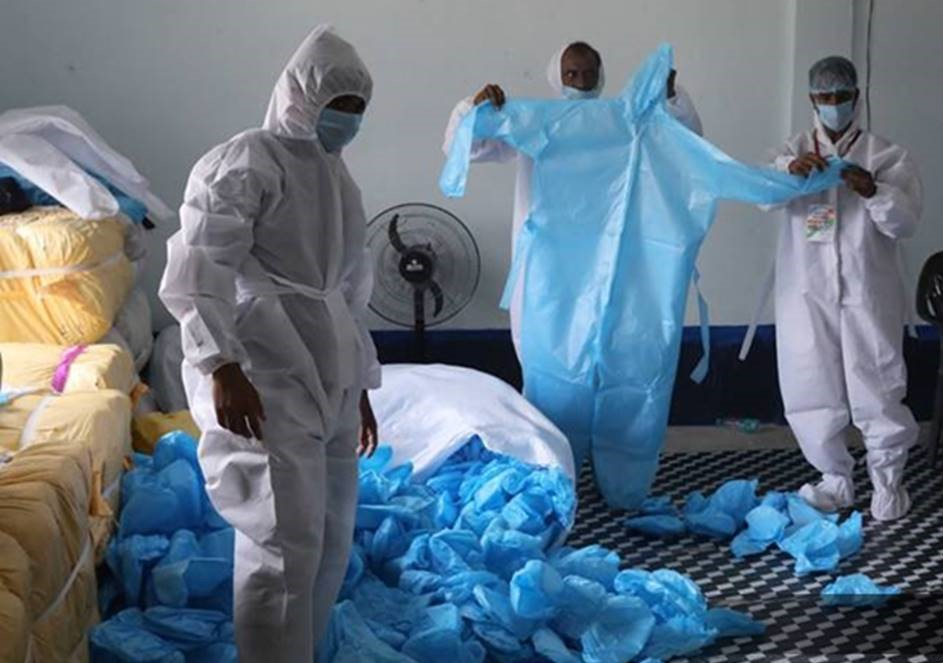

In [ ]:
cppe_ds["train"][0]["image"]

['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask']
{0: 'Coverall', 1: 'Face_Shield', 2: 'Gloves', 3: 'Goggles', 4: 'Mask'}
{'id': [114, 115, 116, 117], 'area': [3796, 1596, 152768, 81002], 'bbox': [[302.0, 109.0, 73.0, 52.0], [810.0, 100.0, 57.0, 28.0], [160.0, 31.0, 248.0, 616.0], [741.0, 68.0, 202.0, 401.0]], 'category': [4, 4, 0, 0]}


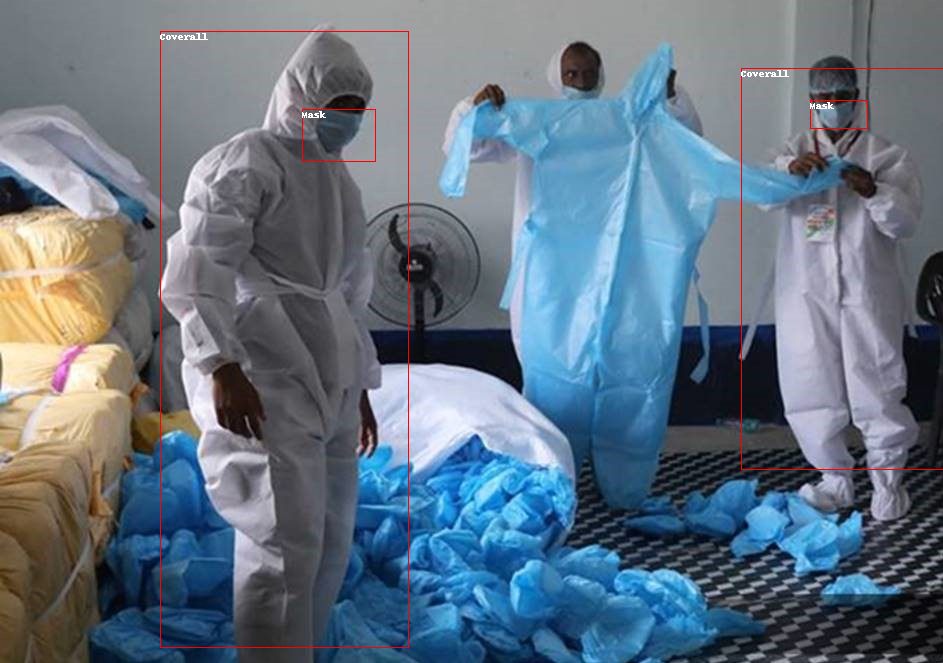

In [ ]:
#Draw the annotations on the image
import numpy as np
import os
from PIL import Image, ImageDraw

image = cppe_ds["train"][0]["image"]
annotations = cppe_ds["train"][0]["objects"]
draw = ImageDraw.Draw(im=image)

categories = cppe_ds["train"].features["objects"].feature["category"].names
print(categories)
id2label = {i: label for i, label in enumerate(categories)}
label2id = {label: i  for i, label in enumerate(categories)}
print(id2label)


print(annotations)
for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    label = annotations["category"][i]
    x, y, w, h = box
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), text=id2label[label], fill="white")

image

To visualize the bounding boxes with associated labels, you can get the labels from the dataset’s metadata, specifically the `category` field. You’ll also want to create dictionaries that map a label id to a label class (`id2label`) and the other way around (`label2id`). You can use them later when setting up the model. Including these maps will make your model reusable by others if you share it on the Hugging Face Hub.

As a final step of getting familiar with the data, explore it for potential issues. One `common problem with datasets for object detection` is `bounding boxes that “stretch” beyond the edge of the image`. Such “runaway” bounding boxes can raise errors during training and should be addressed at this stage. There are a few examples with this issue in this dataset. To keep things simple in this guide, we remove these images from the data.

In [ ]:
remove_idx = [590, 821, 822, 875, 876, 878, 879]
keep = [i for i in range(len(cppe_ds["train"])) if i not in remove_idx]
cppe_ds["train"] = cppe_ds["train"].select(keep)

####**Preprocess the data**
To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model. `AutoImageProcessor` takes care of processing image data to create `pixel_values`, `pixel_mask`, and `labels` that a `DETR model` can train with.

The `image processor` has some `attributes` that you won’t have to worry about:

- `image_mean` = [0.485, 0.456, 0.406 ]
- `image_std` = [0.229, 0.224, 0.225]

These are the `mean and standard deviation used to normalize images during the model pre-training`.
These values are crucial to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

Before passing the images to the image_processor, apply two `preprocessing transformations` to the dataset:

- `Augmenting images`
- `Reformatting annotations` to meet DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library.

Here we use `Albumentations` https://albumentations.ai/docs/ … .This library `ensures that transformations affect the image and update the bounding boxes accordingly`.

The 🤗 Datasets library documentation has a detailed guide on how to augment images for object detection https://huggingface.co/docs/datasets/object_detection, and it uses the exact same dataset as an example.

Apply the same approach here, `resize each image to (480, 480)`, `flip it horizontally`, and `brighten` it:

In [ ]:
import albumentations as A
import numpy as np
import torch

transforms = A.Compose([
    A.Resize(480, 480),
    A.HorizontalFlip(p=1.0),
    A.RandomBrightnessContrast(p=1.0)
], bbox_params=A.BboxParams(format="coco",
                            label_fields=["category"])
)


The `image_processor` expects the each `annotations` of an image to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`, where each dictionary is a `COCO object annotation`.

Let’s add a function to reformat annotations for a single example

In [ ]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []

    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i])
        }
        annotations.append(new_ann)
    # print(annotations)
    return annotations

In [ ]:
#test the function
print(cppe_ds["train"][0]["objects"])
image_id = cppe_ds["train"][0]["image_id"]
object_ids, area, bbox, category = cppe_ds["train"][0]["objects"].values()
formatted_anns(image_id, category, area, bbox)

{'id': [114, 115, 116, 117], 'area': [3796, 1596, 152768, 81002], 'bbox': [[302.0, 109.0, 73.0, 52.0], [810.0, 100.0, 57.0, 28.0], [160.0, 31.0, 248.0, 616.0], [741.0, 68.0, 202.0, 401.0]], 'category': [4, 4, 0, 0]}


[{'image_id': 15,
  'category_id': 4,
  'isCrowd': 0,
  'area': 3796,
  'bbox': [302.0, 109.0, 73.0, 52.0]},
 {'image_id': 15,
  'category_id': 4,
  'isCrowd': 0,
  'area': 1596,
  'bbox': [810.0, 100.0, 57.0, 28.0]},
 {'image_id': 15,
  'category_id': 0,
  'isCrowd': 0,
  'area': 152768,
  'bbox': [160.0, 31.0, 248.0, 616.0]},
 {'image_id': 15,
  'category_id': 0,
  'isCrowd': 0,
  'area': 81002,
  'bbox': [741.0, 68.0, 202.0, 401.0]}]

Now you can `combine the image and annotation transformations` to use on a batch of examples:

In [ ]:
len(cppe_ds["train"]["image_id"])

993

In [ ]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, area, bboxes, categories = [], [], [], []

    for img, objects in zip(examples["image"], examples["objects"]):
        img = np.array(img.convert("RGB"))[:, :, ::-1] #reversing the channels to BGR
        out = transforms(image=img, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_,
         "annotations": formatted_anns(
             image_id=id_, category=cat_, area=ar_, bbox=box_
             )
        }
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    # print(targets)

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Apply this preprocessing function to the entire dataset using 🤗 Datasets `with_transform` method. This method applies transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor with `pixel_values`, a tensor with `pixel_mask`, and `labels`.

In [ ]:
cppe_ds["train"] = cppe_ds["train"].with_transform(transform_aug_ann)
cppe_ds["train"][0]

{'pixel_values': tensor([[[-0.1143, -0.1143, -0.1143,  ...,  0.1597,  0.1597,  0.1597],
          [-0.1143, -0.1143, -0.1143,  ...,  0.1597,  0.1597,  0.1597],
          [-0.1143, -0.1143, -0.1143,  ...,  0.1426,  0.1426,  0.1426],
          ...,
          [-1.2959, -1.2959, -1.3130,  ..., -1.2445, -1.2103, -1.1932],
          [-1.0904, -1.1589, -1.2788,  ..., -1.2274, -1.2103, -1.1932],
          [-0.9534, -1.0733, -1.2445,  ..., -1.2274, -1.2103, -1.1932]],
 
         [[-0.0049, -0.0049, -0.0049,  ...,  0.1877,  0.1877,  0.1877],
          [-0.0049, -0.0049, -0.0049,  ...,  0.1877,  0.1877,  0.1877],
          [-0.0049, -0.0049, -0.0049,  ...,  0.1702,  0.1702,  0.1702],
          ...,
          [-1.2654, -1.2829, -1.3004,  ..., -0.6702, -0.6527, -0.6352],
          [-1.0728, -1.1429, -1.2479,  ..., -0.6527, -0.6352, -0.6352],
          [-0.9328, -1.0378, -1.2129,  ..., -0.6527, -0.6352, -0.6352]],
 
         [[ 0.1999,  0.1999,  0.1999,  ...,  0.3045,  0.3045,  0.3045],
          [ 

You have successfully augmented the individual images and prepared their annotations. However, preprocessing isn’t complete yet.

In the final step, create a `custom collate_fn to batch images together`.

`Pad images` (which are now pixel_values) to the `largest image in a batch`, and `create a corresponding pixel_mask` to indicate which pixels are real (1) and which are padding (0).

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(images=pixel_values,
                                   return_pixel_mask=True,
                                   return_tensors="pt")
    # print(encoding.keys())
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

####**Training the DETR model**
You have done most of the heavy lifting in the previous sections, so now you are ready to train your model! The images in this dataset are still quite large, even after resizing. This means that finetuning this model will require at least one GPU.

Training involves the following steps:

- Load the model with `AutoModelForObjectDetection` using the same checkpoint as in the preprocessing.
- Define your training hyperparameters in `TrainingArguments`.
- Pass the training arguments to `Trainer` along with the `model, dataset, image processor, and data collator`.
- Call `train()` to finetune your model.
- When loading the model from the same checkpoint that you used for the preprocessing, `remember to pass the label2id and id2label maps` that you created earlier from the dataset’s metadata. Additionally, we specify `ignore_mismatched_sizes=True` to `replace the existing classification head with a new one`.

In [ ]:
from transformers import AutoModelForObjectDetection

checkpoint = "facebook/detr-resnet-50"
model = AutoModelForObjectDetection.from_pretrained(checkpoint,
                                                    label2id=label2id,
                                                    id2label=id2label,
                                                    ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In the `TrainingArguments` use `output_dir` to specify where to save your model, then configure `hyperparameters` as you see fit. It is important you do not `remove unused columns` because this will drop the image column. Without the image column, you can’t create pixel_values.

For this reason, set `remove_unused_columns to False`. If you wish to share your model by pushing to the Hub, set `push_to_hub to True` (you must be signed in to Hugging Face to upload your model).



In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_cppe5",
    remove_unused_columns=False,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    fp16=True, #floating point Mixed precision training with AMP or APEX, only works when gpu is enbaled
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    push_to_hub=True,
    hub_strategy="end"
)

Finally, bring everything together, and call `train()`

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=cppe_ds["train"],
    tokenizer=image_processor
)

trainer.train()

TrainOutput(global_step=1250, training_loss=1.9714645446777344, metrics={'train_runtime': 2189.7869, 'train_samples_per_second': 4.535, 'train_steps_per_second': 0.571, 'total_flos': 4.7447108971776e+18, 'train_loss': 1.9714645446777344, 'epoch': 10.0})

If you have set `push_to_hub to True` in the `training_args`, the training checkpoints are pushed to the Hugging Face Hub. Upon training completion, `push the final model to the Hub` as well by calling the `push_to_hub()` method.



In [ ]:
trainer.push_to_hub()

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1704048602.48f430d82fe8.4244.0:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/BhavanaMalla/detr-resnet-50_finetuned_cppe5/tree/main/'

####**Evaluate**

Notice that we didnt actually pass the eval dataset during training.

`Object detection models` are commonly `evaluated` with a set of `COCO-style metrics` https://cocodataset.org/#detection-eval. You can use one of the `existing metrics implementations`, but here you’ll use the one from `torchvision` to `evaluate the final model` that you pushed to the Hub.

To use the `torchvision evaluator`, you’ll `need to prepare a ground truth COCO dataset` i.e you need to prepare your dataset in the format of COCO dataset. The `API to build a COCO dataset` requires the data to be stored in a certain format, so you’ll `need to save images and annotations to disk first`. Just like when you prepared your data for training, the annotations from the `cppe5["test"]` need to be formatted. However, `images should stay as they are`.

The evaluation step requires a bit of work, but it can be split in `three major steps`.

- First, prepare the `cppe5["test"] set`: `format the annotations and save the data to disk`.
- Next, prepare an instance of a `CocoDetection class` that can be used with `cocoevaluator`.
- Finally, `load the metrics` and `run the evaluation`.

In [ ]:
import json
from pathlib import Path

# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox":objects["bbox"][i]
        }
        annotations.append(new_ann)
    return annotations

# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5_val):
    """
    This function creates a folder. It will contain all the images from the validation dataset and a json file that contains all annotations related info
    """
    current_path = Path.cwd()
    output_path = current_path / "cppe5"
    if not output_path.exists():
        print(f"Directory does not exist.. Creating {output_path}...")
        output_path.mkdir(parents=True, exist_ok=True)

    annotations_file_path = output_path / "cppe5_annotations.json"

    #creating the json file that we need, it will have image properties, formatted annotations, categories
    output_json = {}
    output_json["images"] = []
    output_json["annotations"] = []
    for example in cppe5_val:
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": example["image"].width,
                "height": example["image"].height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        formatted_anns = val_formatted_anns(example["image_id"], example["objects"])
        output_json["annotations"].extend(formatted_anns)

    categories_json = [{"supercategory": "none",
                        "id": id,
                        "name": id2label[id]}
                       for id in id2label]
    output_json["categories"] = categories_json

    #dump the output_json into the path we created annotations_file_path
    with open(annotations_file_path, "w") as f:
        json.dump(obj=output_json, fp=f, ensure_ascii=False, indent=4)

    #Now create images in our path
    for img, img_id in zip(cppe5_val["image"], cppe5_val["image_id"]):
        img_path = output_path / f"{img_id}.png"
        img.save(img_path)

    return output_path, annotations_file_path

Next, prepare an instance of a `CocoDetection class` that can be used with `cocoevaluator`.

In [ ]:
!pip install Cython

Ref : https://colab.research.google.com/drive/1xWdoU5StAQ57C6tKo59fkLm5S_ttYj9b#scrollTo=hrNKk_KoROo7

https://github.com/cocodataset/cocoapi/tree/master

In [ ]:
!git clone https://github.com/cocodataset/cocoapi
!pip install -U setuptools
!pip install -U wheel
!make install -C cocoapi/PythonAPI

In [ ]:
import torchvision
from transformers import AutoImageProcessor

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, ann_file):
        super().__init__(root=img_folder, annFile=ann_file)
        self.image_processor = image_processor

    def __getitem__(self, index: int):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(index)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target
        image_id = self.ids[index]
        target = {"image_id": image_id,
                  "annotations": target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() ## remove batch dimension
        target = encoding["labels"][0] ## remove batch dimension

        return {"pixel_values": pixel_values,
                "labels": target}

#Lets process the valdataset to be in cocoformat
loaded_processor = AutoImageProcessor.from_pretrained("BhavanaMalla/detr-resnet-50_finetuned_cppe5")

imgs_path, anns_json_path = save_cppe5_annotation_file_images(cppe5_val=cppe_ds["test"])
#instantiate the CocoDetection that converts our images and annotations into coco format - https://pytorch.org/vision/stable/_modules/torchvision/datasets/coco.html#CocoDetection
test_ds_coco_format = CocoDetection(img_folder=imgs_path, ann_file=anns_json_path, image_processor=loaded_processor)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Finally, load the metrics and run the evaluation.

In [ ]:
# import evaluate
# from tqdm import tqdm
# from transformers import AutoModelForObjectDetection
# import torch
# from torch.utils.data import DataLoader

# #Loaded the model from repo
# loaded_model = AutoModelForObjectDetection.from_pretrained("BhavanaMalla/detr-resnet-50_finetuned_cppe5")

# #loaded the coco evaluation metrics from this repo
# metric = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)

# #Get the val dataloader
# val_dataloader = DataLoader(dataset=test_ds_coco_format,
#                             batch_size=8,
#                             shuffle=False,
#                             num_workers=2,
#                             collate_fn=collate_fn)

# loaded_model.eval()
# with torch.inference_mode():
#     for idx, batch in enumerate(tqdm(val_dataloader)):
#         pixel_values, pixel_mask = batch["pixel_values"], batch["pixel_mask"]

#         labels = [{k: v for k, v in t.items()} for t in batch["labels"]]# these are in DETR format, resized + normalized

#         # forward pass
#         outputs = loaded_model(pixel_values=pixel_values, pixel_mask=pixel_mask)

#         orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
#         results = loaded_processor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
#         metric.add(predicition=results, reference=labels)
#         del batch

# results = metric.compute()
# results



####**Above repo is not working for coco evalaution. Hence downloading the cocoevaluator from detr library itself. Following**
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Evaluating_DETR_on_COCO_validation_2017.ipynb
- https://github.com/facebookresearch/detr/blob/main/datasets/coco.py

In [ ]:
# ! git clone https://github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
import detr
from detr.datasets import get_coco_api_from_dataset
from detr.datasets.coco_eval import CocoEvaluator

# base_ds = test_ds_coco_format.coco
base_ds = get_coco_api_from_dataset(test_ds_coco_format)  # this is actually just calling the coco attribute
iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths
base_ds

In [ ]:
# from detr.datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
import torch
from transformers import AutoModelForObjectDetection
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Loaded the model from repo
loaded_model = AutoModelForObjectDetection.from_pretrained("BhavanaMalla/detr-resnet-50_finetuned_cppe5")

loaded_model.to(device)

#Get the val dataloader
val_dataloader = DataLoader(dataset=test_ds_coco_format,
                            batch_size=8,
                            shuffle=False,
                            num_workers=2,
                            collate_fn=collate_fn)

print("Running evaluation...")

# let's limit the number of batches for now
nbatches = 50

loaded_model.eval()
for idx, batch in enumerate(tqdm(val_dataloader)):
    if idx > nbatches:
        break

    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized
    # forward pass
    with torch.inference_mode():
        outputs = loaded_model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    # print(orig_target_sizes.shape)
    # print(outputs)
    results = loaded_processor.post_process_object_detection(outputs=outputs, target_sizes=orig_target_sizes) # convert outputs to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)
    del batch


cuda
Running evaluation...


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
coco_evaluator

In [ ]:
coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.040
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

These results can be further improved by adjusting the hyperparameters in TrainingArguments. Give it a go!



####**Inference**
Now that you have finetuned a DETR model, evaluated it, and uploaded it to the Hugging Face Hub, you can use it for inference. The simplest way to try out your finetuned model for inference is to use it in a `Pipeline`. Instantiate a pipeline for object detection with your model, and pass an image to it:

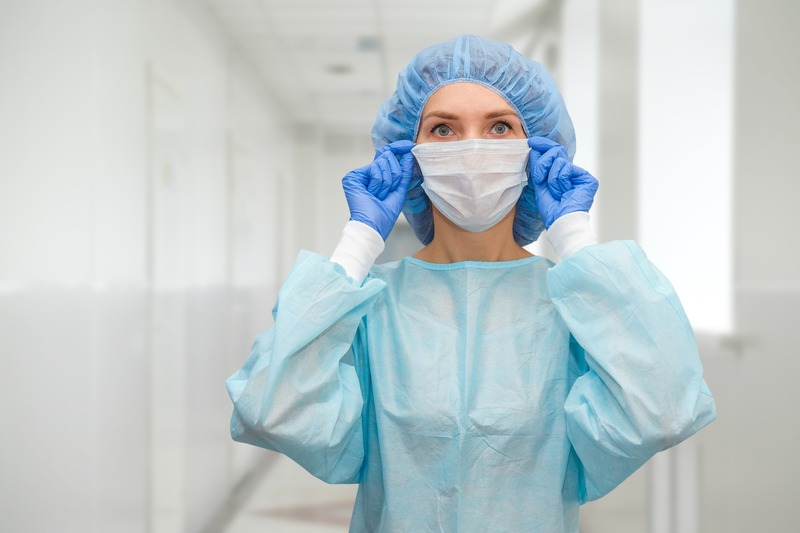

In [ ]:
import requests
from PIL import Image
from transformers import pipeline

url = "https://i.imgur.com/2lnWoly.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image


In [ ]:
object_detector = pipeline(task="object-detection",
                           model="detr-resnet-50_finetuned_cppe5")

# object_detector = pipeline(task="object-detection",
#                            model="facebook/detr-resnet-50")
# object_detector("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png")
object_detector(image)

[]

You can also manually replicate the results of the pipeline if you’d like:

In [ ]:
# image_processor = AutoImageProcessor.from_pretrained("BhavanaMalla/detr-resnet-50_finetuned_cppe5")
# model = AutoModelForObjectDetection.from_pretrained("BhavanaMalla/detr-resnet-50_finetuned_cppe5")

image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-50")

with torch.inference_mode():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    # print(outputs)
    # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
    target_sizes = torch.tensor([image.size[::-1]])
    # Convert outputs (bounding boxes and class logits) to COCO API
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)
    # print(len(results))
    # print(results)

i = 0  # Retrieve predictions for the first image
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects and rescaled box coordinates
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

# results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]
# for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
#     box = [round(i, 2) for i in box.tolist()]
#     print(
#         f"Detected {model.config.id2label[label.item()]} with confidence "
#         f"{round(score.item(), 3)} at location {box}"
#     )

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initiali

Detected person with confidence 0.999 at location [221.71, 31.2, 720.36, 526.38]


Let’s plot the result:

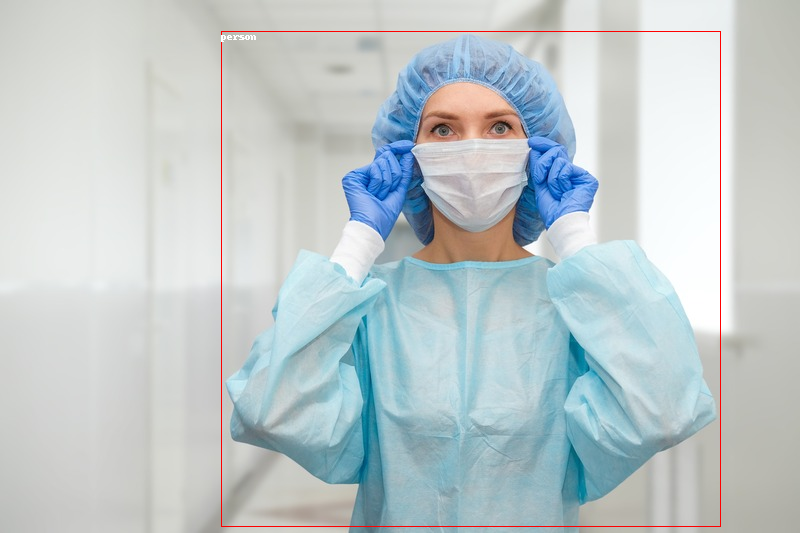

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

draw = ImageDraw.Draw(image)
i = 0  # Retrieve predictions for the first image
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for score, label, box in zip(scores, labels, boxes):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")
image

###**Zero Shot Object Detection**

Traditionally, models used for object detection require labeled image datasets for training, and are limited to detecting the set of classes from the training data.

`Zero-shot object detection` is supported by the `OWL-ViT model` which uses a different approach. `OWL-ViT` is an `open-vocabulary object detector`. It means that it `can detect objects in images based on free-text queries without the need to fine-tune the model on labeled datasets`.

OWL-ViT `leverages multi-modal representations to perform open-vocabulary detection`. It combines `CLIP with lightweight object classification and localization heads`.

`Open-vocabulary detection` is achieved by `embedding free-text queries with the text encoder of CLIP and using them as input to the object classification and localization heads`. Associate images and their corresponding textual descriptions, and ViT processes image patches as inputs.

The **authors of OWL-ViT first trained CLIP from scratch and then fine-tuned OWL-ViT end to end on standard object detection datasets using a bipartite matching loss**.

With this approach, **the model can detect objects based on textual descriptions without prior training on labeled datasets**.

In this guide, you will learn how to use OWL-ViT:

- to detect objects based on text prompts
- for batch object detection
- for image-guided object detection

Before you begin, make sure you have all the necessary libraries installed:

In [ ]:
#!pip install -q transformers

####**Zero-shot object detection pipeline**
The simplest way to try out `inference` with OWL-ViT is to use it in a `pipeline()`. Instantiate a `pipeline for zero-shot object detection from a checkpoint` on the Hugging Face Hub:

In [ ]:
from transformers import pipeline

checkpoint = "google/owlvit-base-patch32"
zeroshot_detector = pipeline(task="zero-shot-object-detection", model=checkpoint)

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Next, choose an image you’d like to detect objects in. Here we’ll use the image of astronaut Eileen Collins that is a part of the NASA Great Images dataset.

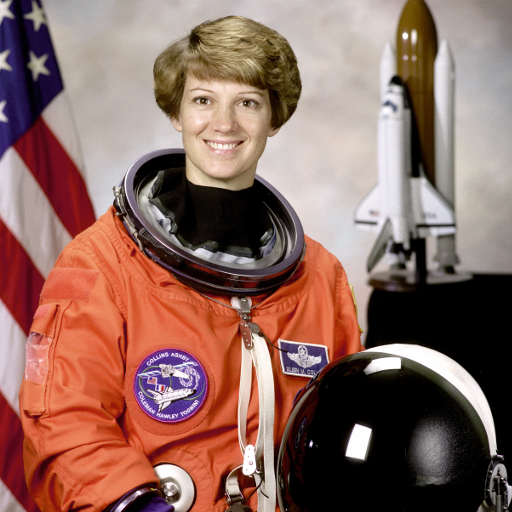

In [ ]:
import skimage
import numpy as np
from PIL import Image

img = skimage.data.astronaut()

img = Image.fromarray(np.uint8(img)).convert("RGB")

img

Pass the image and the candidate object labels to look for to the pipeline.

Here we pass the image directly; other suitable options include a local path to an image or an image url. We also pass text descriptions for all items we want to query the image for.

In [ ]:
predictions = zeroshot_detector(
    image=img, candidate_labels=["human face", "rocket", "nasa badge", "star-spangled banner"]
)
predictions

[{'score': 0.35713592171669006,
  'label': 'human face',
  'box': {'xmin': 180, 'ymin': 71, 'xmax': 271, 'ymax': 178}},
 {'score': 0.2809974253177643,
  'label': 'nasa badge',
  'box': {'xmin': 129, 'ymin': 348, 'xmax': 206, 'ymax': 427}},
 {'score': 0.21102380752563477,
  'label': 'rocket',
  'box': {'xmin': 350, 'ymin': -1, 'xmax': 468, 'ymax': 288}},
 {'score': 0.13790476322174072,
  'label': 'star-spangled banner',
  'box': {'xmin': 1, 'ymin': 1, 'xmax': 105, 'ymax': 509}},
 {'score': 0.11950051039457321,
  'label': 'nasa badge',
  'box': {'xmin': 277, 'ymin': 338, 'xmax': 327, 'ymax': 380}},
 {'score': 0.10649295151233673,
  'label': 'rocket',
  'box': {'xmin': 358, 'ymin': 64, 'xmax': 424, 'ymax': 280}}]

Let’s visualize the predictions

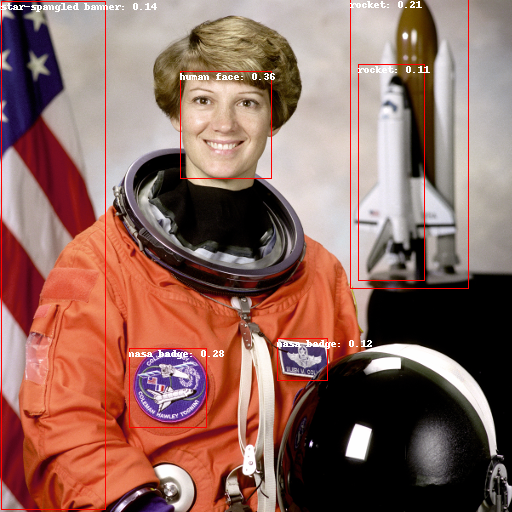

In [ ]:
from PIL import Image, ImageDraw

draw = ImageDraw.Draw(img)
for prediction in predictions:
    box = prediction["box"]
    xmin, ymin, xmax, ymax = box.values()
    label = prediction["label"]
    score = prediction["score"]
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), fill="white", text=f"{label}: {round(score, 2)}")
img

####**Text-prompted zero-shot object detection by hand**
Now that you’ve seen how to use the zero-shot object detection pipeline, let’s replicate the same result manually.

Start by loading the model and associated processor from a checkpoint on the Hugging Face Hub. Here we’ll use the same checkpoint as before:

In [ ]:
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint) #Autoprocessor bcoz the checkpoint is multimodal
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

In [ ]:
model

OwlViTForObjectDetection(
  (owlvit): OwlViTModel(
    (text_model): OwlViTTextTransformer(
      (embeddings): OwlViTTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(16, 512)
      )
      (encoder): OwlViTEncoder(
        (layers): ModuleList(
          (0-11): 12 x OwlViTEncoderLayer(
            (self_attn): OwlViTAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): OwlViTMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_

In [ ]:
processor

OwlViTProcessor:
- image_processor: OwlViTImageProcessor {
  "crop_size": {
    "height": 768,
    "width": 768
  },
  "do_center_crop": false,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "OwlViTFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "OwlViTImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "OwlViTProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 768,
    "width": 768
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='google/owlvit-base-patch32', vocab_size=49408, model_max_length=16, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '!'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: Add

Let’s take a different image to switch things up.

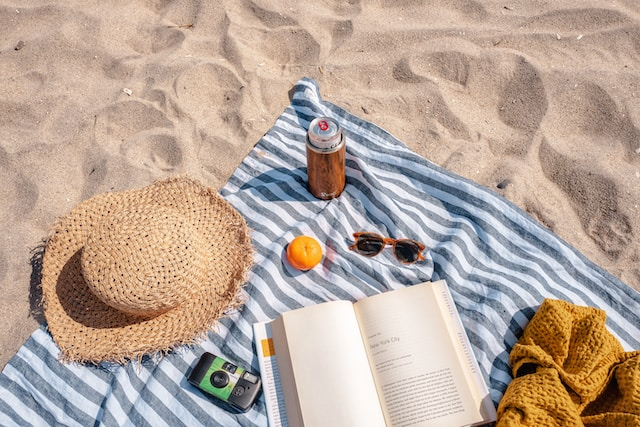

In [ ]:
import requests
from PIL import Image

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
img  = Image.open(requests.get(url, stream=True).raw)
img

Use the `processor` to `prepare the inputs` for the model. The `processor` combines an `image processor` that prepares the `image` for the model by resizing and normalizing it, and a `CLIPTokenizer` that takes care of the `text inputs`.

In [ ]:
text_queries = ["hat", "book", "sunglasses", "camera"]
inputs = processor(images=img, text=text_queries, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,  3801, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  1116, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406, 12906, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  3934, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'pixel_values': tensor([[[[ 1.2442,  1.1712,  1.2296,  ...,  0.9668,  0.9084,  0.9668],
          [ 1.3026,  1.2296,  1.2734,  ...,  0.9522,  0.9230,  0.9668],
          [ 1.3756,  1.3172,  1.3464,  ...,  0.9

Pass the inputs through the model, post-process, and visualize the results.

Since the image processor resized images before feeding them to the model, you need to use the `post_process_object_detection()` method to make sure the predicted bounding boxes have the correct coordinates relative to the original image

In [ ]:
import torch

img.size, img.size[::-1], torch.tensor([img.size[::-1]])

((640, 427), (427, 640), tensor([[427, 640]]))

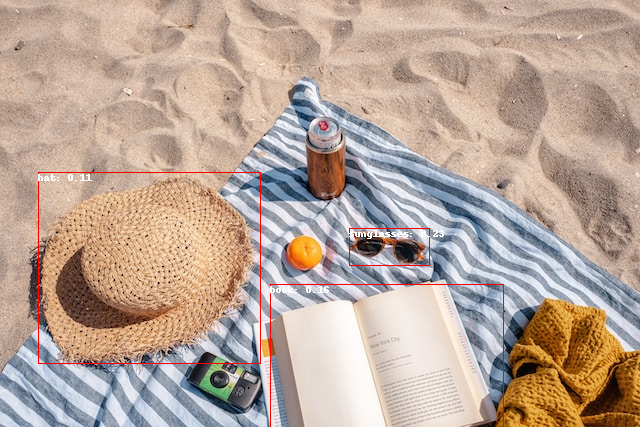

In [ ]:
import torch
from PIL import Image, ImageDraw

model.eval()
with torch.inference_mode():
    outputs = model(**inputs)
    target_sizes = torch.tensor([img.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)

draw = ImageDraw.Draw(img)
i=0 #accesing the first image boxes, scores and labels, here we have only one image
boxes, scores, labels = results[i]["boxes"].tolist(), results[i]["scores"].tolist(), results[i]["labels"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score, 2)}", fill="white")
img



####**Batch processing**
You can pass multiple sets of images and text queries to search for different (or same) objects in several images. Let’s use both an astronaut image and the beach image together.

For batch processing, you should pass text queries as a nested list to the processor and images as lists of PIL images, PyTorch tensors, or NumPy arrays.

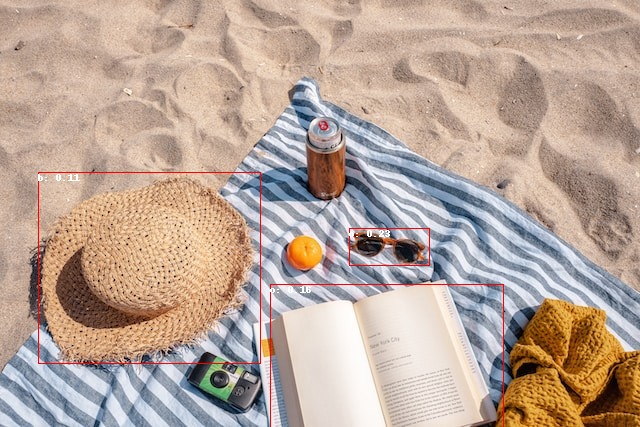

In [ ]:
import skimage
import numpy as np
import requests
import torch
from PIL import Image, ImageDraw
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint) #Autoprocessor bcoz the checkpoint is multimodal
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)

astronaut = skimage.data.astronaut()
img_1 = Image.fromarray(np.uint8(astronaut)).convert("RGB")

url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
img_2 = Image.open(requests.get(url, stream=True).raw)

img_list = [img_1, img_2]
text_queries_list = [["human face", "rocket", "nasa badge", "star-spangled banner"],
                     ["hat", "book", "sunglasses", "camera"]]

inputs = processor(images=img_list, text=text_queries_list, return_tensors="pt")


#Inference of batch
model.eval()
with torch.inference_mode():
    outputs = model(**inputs)
    target_sizes = [x.size[::-1] for x in img_list]
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)

#accesing the second image via index and then access its boxes, scores and labels, here we have only one image
i=1
draw = ImageDraw.Draw(img_list[i])
boxes, scores, labels = results[i]["boxes"].tolist(), results[i]["scores"].tolist(), results[i]["labels"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[i][label]}: {round(score, 2)}", fill="white")
img_list[i]


####**Image-guided object detection**
In addition to zero-shot object detection with text queries, `OWL-ViT offers image-guided object detection`. This means you can use an `image query` to `find similar objects in the target image`.

`Unlike text queries, only a single example image is allowed`.

Let’s take an image with two cats on a couch as a target image, and an image of a single cat as a query:

In [ ]:
import requests
from PIL import Image

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open(requests.get(url, stream=True).raw)

query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

Let’s take a quick look at the images:

In [ ]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)
plt.show()

In the `preprocessing step`, instead of `text queries`, you now need to use `query_images`:

In [ ]:
import skimage
import numpy as np
import requests
import torch
from PIL import Image, ImageDraw
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint) #Autoprocessor bcoz the checkpoint is multimodal
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)

inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

For `predictions`, instead of `passing the inputs to the model`, pass them to `image_guided_detection()` and post process using `post_process_image_guided_detection()`

Draw the predictions as before except now there are no labels.

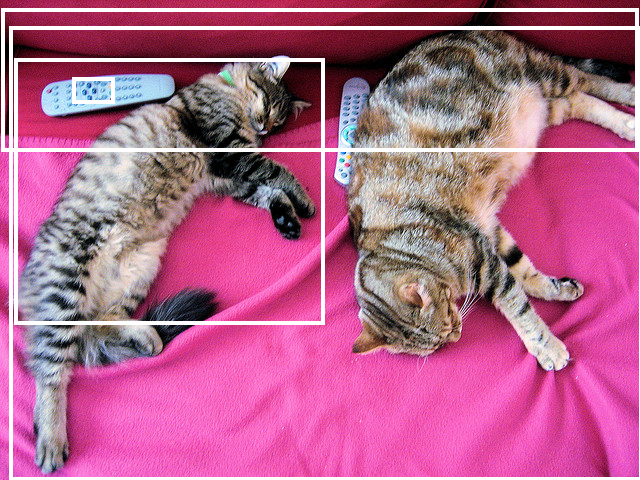

In [ ]:
#Inference of image guided detection
import torch

model.eval()
with torch.inference_mode():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

#accesing the target image boxes, scores and labels, here we have only one image
# print(results)
draw = ImageDraw.Draw(image_target)
boxes, scores = results["boxes"].tolist(), results["scores"].tolist()

for box, score in zip(boxes, scores):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)
image_target

###**Zero Shot Image Classification**

####**With pipeline**

In [ ]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"

zeroshot_classifier = pipeline(task="zero-shot-image-classification", model=checkpoint)
zeroshot_classifier

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


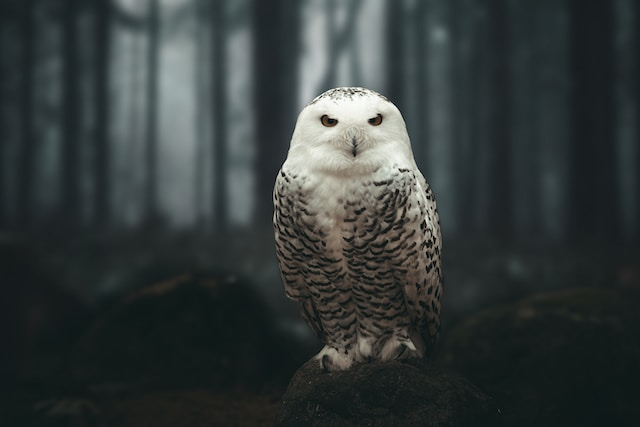

In [ ]:
#Next, choose an image you’d like to classify.
from PIL import Image
import requests

url = "https://unsplash.com/photos/g8oS8-82DxI/download?ixid=MnwxMjA3fDB8MXx0b3BpY3x8SnBnNktpZGwtSGt8fHx8fDJ8fDE2NzgxMDYwODc&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

image

Pass the image and the candidate object labels to the pipeline. Here we pass the image directly; other suitable options include a local path to an image or an image url. The candidate labels can be simple words like in this example, or more descriptive.

In [ ]:
candidate_labels = ["fox", "bear", "seagull", "owl"]
preds = zeroshot_classifier(images=image, candidate_labels=candidate_labels)
preds

[{'score': 0.9993506073951721, 'label': 'owl'},
 {'score': 0.0004959474899806082, 'label': 'seagull'},
 {'score': 8.070819603744894e-05, 'label': 'fox'},
 {'score': 7.274257222888991e-05, 'label': 'bear'}]

####**Zero-shot image classification by hand
Now that you’ve seen how to use the zero-shot image classification pipeline, let’s take a look how you can run zero-shot image classification manually.

Start by loading the model and associated processor from a checkpoint on the Hugging Face Hub. Here we’ll use the same checkpoint as before:

In [ ]:
from transformers import AutoModelForZeroShotImageClassification, AutoProcessor
from PIL import Image, ImageDraw
import requests
import torch

checkpoint = "openai/clip-vit-large-patch14"

model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

url = "https://unsplash.com/photos/xBRQfR2bqNI/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjc4Mzg4ODEx&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

candidate_labels = ["tree", "car", "bike", "cat"]

inputs = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)

model.eval()
with torch.inference_mode():
    outputs = model(**inputs)

print(outputs.keys())
logits = outputs["logits_per_image"][0] #first image logits
probs = torch.softmax(logits, dim=-1).numpy()
print(probs)
scores = probs.tolist()

result = [{"score": score, "label": candidate_label}
    for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0]) #sorted based on -negative probs i.e ascending order
]
result



`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])
[2.9800704e-04 9.9872333e-01 9.4798522e-04 3.0776235e-05]


[{'score': 0.9987233, 'label': 'car'},
 {'score': 0.0009479852, 'label': 'bike'},
 {'score': 0.00029800704, 'label': 'tree'},
 {'score': 3.0776235e-05, 'label': 'cat'}]

In [ ]:
outputs["logits_per_image"]

tensor([[11.7387, 19.8559, 12.8960,  9.4684]])

###**Knowledge Distillation for Computer Vision**

`Knowledge distillation` is a technique used to `transfer knowledge from a larger, more complex model (teacher) to a smaller, simpler model (student)`.

To distill knowledge from one model to another, we take a `pre-trained teacher model trained on a certain task` (image classification for this case) and `randomly initialize a student model` to be trained on image classification.

Next, we `train the student model to minimize the difference between it’s outputs and the teacher’s outputs`, thus making it mimic the behavior.

It was first introduced in `Distilling the Knowledge in a Neural Network by Hinton et al` https://arxiv.org/abs/1503.02531.

In this guide, we will do `task-specific knowledge distillation`. We will use the `beans dataset` for this.

This guide demonstrates how you can `distill a fine-tuned ViT model (teacher model)` to a `MobileNet (student model)` using the Trainer API of 🤗 Transformers.

Let’s install the libraries needed for distillation and evaluating the process.

In [ ]:
!pip install transformers datasets accelerate tensorboard evaluate --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In this example, we are using the `merve/beans-vit-224` model as teacher model. It’s an `image classification model, based on google/vit-base-patch16-224-in21k fine-tuned on beans dataset`.

We will `distill this model to a randomly initialized MobileNetV2`.

We will now load the dataset.

In [ ]:
import datasets
from datasets import load_dataset

beans_ds = load_dataset("beans")
beans_ds

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

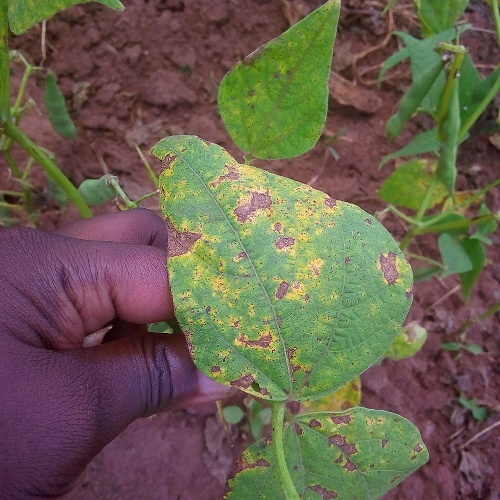

In [ ]:
beans_ds["train"][1]["image"]

We can use an image processor from either of the models, as in this case they return the same output with same resolution. We will use the `map()` method of dataset to apply the preprocessing to every split of the dataset.

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "merve/beans-vit-224"
teacher_processor = AutoImageProcessor.from_pretrained(checkpoint)

def process(examples):
    processed_inputs = teacher_processor(examples["image"])
    return processed_inputs


processed_ds = beans_ds.map(process, batched=True)

train_ds = processed_ds["train"]
test_ds = processed_ds["test"]
validation_ds = processed_ds["validation"]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Map:   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
teacher_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
processed_ds["train"][0]["pixel_values"]

Exception ignored in: <function _xla_gc_callback at 0x7bfa9cf4e3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7bfa9cf4e3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7bfa9cf4e3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7bfa9cf4e3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_

In [ ]:
from transformers import AutoModelForImageClassification, MobileNetV2ForImageClassification, MobileNetV2Config

checkpoint = "merve/beans-vit-224"
teacher_model = AutoModelForImageClassification.from_pretrained(checkpoint)
num_labels = len(processed_ds["train"].features["labels"].names)
print(f"Labels: {num_labels}")

# initialize models
teacher_model = AutoModelForImageClassification.from_pretrained(checkpoint,
                                                                num_labels=num_labels,
                                                                ignore_mismatched_sizes=True
                                                                )
teacher_ouputs = teacher_model(**processed_ds["train"]["pixel_values"])

# # training MobileNetV2 from scratch
# student_config = MobileNetV2Config()
# student_config.num_labels = num_labels
# student_model = MobileNetV2ForImageClassification(student_config)

Labels: 3


AttributeError: ignored

Essentially, we want the student model (a randomly initialized `MobileNet`) to mimic the teacher model (`fine-tuned vision transformer`).

To achieve this, we:
-  `first get the logits output from the teacher and the student`.
- Then, we `divide each of them by the parameter temperature` which controls the importance of each soft target.
- A parameter called `lambda` weighs the `importance of the distillation loss`.

In this example, we will use `temperature=5 and lambda=0.5`.

We will use the `Kullback-Leibler Divergence loss` to `compute the divergence between the student and teacher`.

Given two data distribution P and Q, KL Divergence explains how much extra information we need to represent P using Q. If two are identical, their KL divergence is zero, as there’s no other information needed to explain P from Q. Thus, in the context of knowledge distillation, KL divergence is useful.

In [ ]:
from transformers import Trainer, TrainingArguments
from torch import nn
import torch.nn.functional as F
import torch

class ImageDistilTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, student_model=None, temperature=5, lambda_=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        self.loss_fn = nn.KLDivLoss(reduction="batchmean")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.teacher.to(device)
        self.teacher.eval()
        self.temperature = temperature
        self.lambda_ = lambda_

    def compute_loss(self, student, inputs, return_outputs=False):
        """ Default loss computed by Trainer.
        By default, all models return the loss in the first element.
        """
        student_outputs = self.model(**inputs)

        with torch.inference_mode():
            teacher_outputs = self.teacher(**inputs)

        # Compute soft targets for teacher and student
        soft_teacher = F.softmax(teacher_outputs.logits / self.temperature, dim=-1)
        soft_student = F.softmax(student_outputs.logits / self.temperature, dim=-1)

        #Compute the distillation_loss
        distillation_loss = self.loss_fn(soft_student, soft_teacher) * (self.temperature**2)

        # Compute the true label loss
        student_target_loss = student_outputs.loss

        # Calculate final loss
        loss = (1 - self.lambda_) * student_target_loss + (self.lambda_) * distillation_loss

        return (loss, student_outputs) if return_outputs else loss


We will now login to Hugging Face Hub so we can push our model to the Hugging Face Hub through the Trainer.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Let’s set the `TrainingArguments`, the `teacher model` and the `student model`.

In [ ]:
from transformers import TrainingArguments, AutoModelForImageClassification, MobileNetV2ForImageClassification, MobileNetV2Config

checkpoint = "merve/beans-vit-224"
teacher_model = AutoModelForImageClassification.from_pretrained(checkpoint)
num_labels = len(processed_ds["train"].features["labels"].names)


# initialize models
teacher_model = AutoModelForImageClassification.from_pretrained(checkpoint,
                                                                num_labels=num_labels,
                                                                ignore_mismatched_sizes=True
                                                                )

# training MobileNetV2 from scratch
student_config = MobileNetV2Config()
student_config.num_labels = num_labels
student_model = MobileNetV2ForImageClassification(student_config)

repo_name = "BhavanaMalla/distill_ViT_to_MobileNet"
#Trainingarguments
training_args = TrainingArguments(
    output_dir="distill_ViT_to_MobileNet",
    num_train_epochs=1,
    # fp16=True,
    logging_dir=f"{repo_name}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=repo_name,
)

We can use `compute_metrics` function to evaluate our model on the test set. This function will be used during the training process to compute the accuracy & f1 of our model.

In [ ]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = metric.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

Let’s initialize the `Trainer` with the training arguments we defined. We will also initialize our `data collator`.

In [ ]:
from transformers import Trainer, DefaultDataCollator

collate_fn = DefaultDataCollator(return_tensors="pt")
trainer = ImageDistilTrainer(
    model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=validation_ds,
    data_collator=collate_fn,
    tokenizer=teacher_processor,
    compute_metrics=compute_metrics,
    temperature=5,
    lambda_=0.5
)

In [ ]:
trainer.train()
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/BhavanaMalla/distill_ViT_to_MobileNet/tree/main/'

We can evaluate the model on the test set.



In [ ]:
trainer.evaluate(processed_ds["test"])

{'eval_loss': -17.03380584716797,
 'eval_accuracy': 0.3984375,
 'eval_runtime': 102.7346,
 'eval_samples_per_second': 1.246,
 'eval_steps_per_second': 0.156,
 'epoch': 1.0}

On test set, our model reaches 72 percent accuracy. To have a sanity check over efficiency of distillation, we also trained MobileNet on the beans dataset from scratch with the same hyperparameters and observed 63 percent accuracy on the test set. We invite the readers to try different pre-trained teacher models, student architectures, distillation parameters and report their findings. The training logs and checkpoints for distilled model can be found in this repository https://huggingface.co/merve/vit-mobilenet-beans-224, and MobileNetV2 trained from scratch can be found in this repository. https://huggingface.co/merve/resnet-mobilenet-beans-5